In [225]:
import tensorflow as tf
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np

In [226]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [227]:
train_images=tf.data.Dataset.list_files('/kaggle/input/face-dataset/aug_data/train/images/*.JPG',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)


In [228]:
val_images=tf.data.Dataset.list_files('/kaggle/input/face-dataset/aug_data/valid/images/*.JPG',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)


In [229]:
for image in val_images:
    if image.shape!=(120,120,3):
        print('false')
        break

In [230]:
def load_labels(x):
    label_file = x.numpy().decode("utf-8")
    with open(label_file, "r") as f:
        my_json_object = json.load(f)
        label = my_json_object["class"]
        my_bounding = my_json_object['bbox']
        
        
        
        if label == "Aaditya":
            one_value=[1,0]
        elif label[0] == "noone":
            one_value=[0,1]
        
        
            
            
        return one_value,my_bounding

            
        
        



In [231]:
train_labels = tf.data.Dataset.list_files('/kaggle/input/face-dataset/aug_data/train/labels/*.json', shuffle=False)
train_labels=train_labels.map(lambda x :tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [232]:
for elements in train_labels.take(1):
    print(elements)

(<tf.Tensor: shape=(2,), dtype=uint8, numpy=array([1, 0], dtype=uint8)>, <tf.Tensor: shape=(4,), dtype=float16, numpy=array([0.3782, 0.457 , 0.5776, 0.8315], dtype=float16)>)


In [233]:
val_labels = tf.data.Dataset.list_files('/kaggle/input/face-dataset/aug_data/valid/labels/*.json', shuffle=False)
val_labels=val_labels.map(lambda x :tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [234]:
len(train_images)

1440

In [235]:
len(train_labels)

1440

In [236]:
len(val_images)

360

In [237]:
len(val_labels)

360

In [238]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(500)
train = train.batch(16)
train = train.prefetch(8)

In [239]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(16)
val = val.prefetch(8)

In [240]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,InputLayer,BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential

vgg_base_one = VGG16(include_top=False, input_shape=(120, 120, 3))

# Freeze the VGG16 base model
vgg_base_one.trainable = False



vgg_base_two = VGG16(include_top=False, input_shape=(120, 120, 3))

# Freeze the VGG16 base model
vgg_base_two.trainable = False




In [241]:
def build_classifier():
    model=Sequential()
    model.add(InputLayer((120,120,3)))
    model.add(vgg_base_one)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(2048,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation="softmax"))
    
    return model
    
    

In [242]:
classifier=build_classifier()
classifier.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_13         │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,769,410 (60.16 MB)

 Trainable params: 1,054,722 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [254]:
def build_bounding():
    model=Sequential()
    model.add(InputLayer((120,120,3)))
    model.add(vgg_base_two)
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    
    model.add(Dense(128,activation="relu"))
    
    model.add(Dense(4,activation="sigmoid"))
    
    return model
    
    

In [255]:
bounding=build_bounding()
bounding.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,928,004 (60.76 MB)

 Trainable params: 1,213,316 (4.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [256]:
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy




In [257]:
def localization_loss(y_true, yhat):            
    starting_coord_loss = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    height_width_loss = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return starting_coord_loss + height_width_loss

In [258]:
#class implementation
from tensorflow.keras import Model
class facerec(Model):
    def __init__(self, classifier, bounding, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        self.classifier = classifier
        self.bounding = bounding

    def compile(self, c_opt, b_opt, c_loss, b_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.c_opt = c_opt
        self.b_opt = b_opt
        self.c_loss = c_loss
        self.b_loss = b_loss
        self.classifier_metric = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        

    def train_step(self,batches):
        images,y=batches
        my_class=y[0]
        my_bounding=y[1]
        with tf.GradientTape() as c_tape:
            classifier_output=self.classifier(images,training=True)
            classifier_loss=self.c_loss(my_class,classifier_output)
            
        cgrad = c_tape.gradient(classifier_loss, self.classifier.trainable_variables)
        self.c_opt.apply_gradients(zip(cgrad, self.classifier.trainable_variables))
        
        
        with tf.GradientTape() as b_tape:
            bounding_output=self.bounding(images,training=True)
            bounding_loss=self.b_loss(tf.cast(my_bounding, tf.float32),bounding_output)
            
            
        bgrad = b_tape.gradient(bounding_loss, self.bounding.trainable_variables)
        self.b_opt.apply_gradients(zip(bgrad, self.bounding.trainable_variables))
        
        
        self.classifier_metric.update_state(my_class, classifier_output)
        classifier_acc = self.classifier_metric.result()
        
        
        
        

        
        return {"classifier_loss": classifier_loss, "bounding_loss": bounding_loss,"total_loss":classifier_loss+bounding_loss,"Accuracy":classifier_acc}
    
            
        
    

In [248]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [259]:
optimizer1 = Adam(learning_rate=0.0001)
optimizer2 = Adam()

In [260]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy




In [261]:
model1=facerec(classifier,bounding)

In [262]:
model1.compile(optimizer1,optimizer2,CategoricalCrossentropy(),localization_loss,run_eagerly=True)

In [263]:
history=model1.fit(train,epochs=200,verbose=1)

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - Accuracy: 0.9866 - bounding_loss: 0.9265 - classifier_loss: 0.0274 - total_loss: 0.9538
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - Accuracy: 0.9946 - bounding_loss: 0.2641 - classifier_loss: 0.0160 - total_loss: 0.2801
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - Accuracy: 0.9822 - bounding_loss: 0.1451 - classifier_loss: 0.0186 - total_loss: 0.1637
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - Accuracy: 0.9906 - bounding_loss: 0.0958 - classifier_loss: 0.0150 - total_loss: 0.1108
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - Accuracy: 0.9976 - bounding_loss: 0.0569 - classifier_loss: 0.0115 - total_loss: 0.0684
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - Accuracy: 0.9953 - bounding_loss: 0.0679 - classifier_loss: 0.0117 - total_loss: 0.0796
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - Accuracy: 0.9977 - bounding_loss: 0.1139 - classifier_loss: 0.0110 - total_loss:

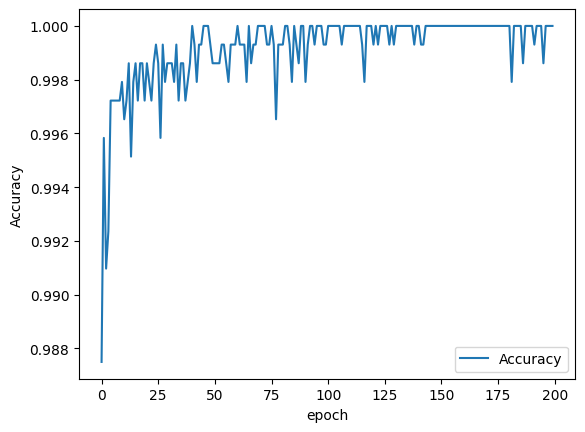

In [264]:
plt.plot(history.history['Accuracy'])

plt.legend(['Accuracy'])
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()

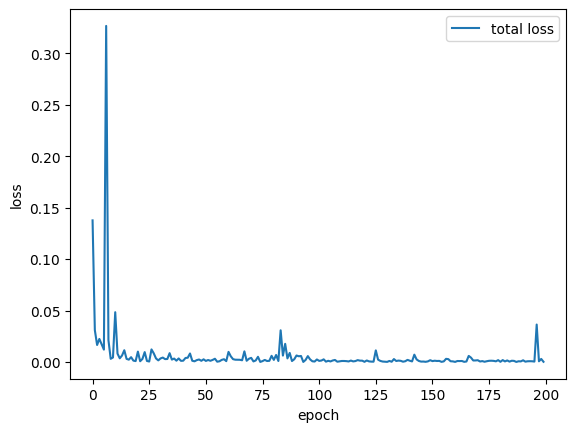

In [265]:
plt.plot(history.history['bounding_loss'])

plt.legend(['total loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [266]:
# Save the model to a local directory
classifier.save('/kaggle/working/classifierfive.h5')

In [267]:
# Save the model to a local directory
bounding.save('/kaggle/working/boundingfive.h5')